# CM2604 Machine Learning Coursework: Telco Customer Churn Prediction

This notebook implements a binary classification model for customer churn using the Telco dataset.
- Task 1: Exploratory Data Analysis (EDA)
- Task 2: Preprocessing, Decision Tree and Neural Network models with hyperparameter tuning
- Evaluation and comparison

Dataset: WA_Fn-UseC_-Telco-Customer-Churn.csv (from Kaggle)
Author: Pavishanth Sujeevan
Date: December 11, 2025

In [1]:
# General and data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Preprocessing and metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# TensorFlow/Keras for Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# SciKeras for Keras + Scikit-learn integration
from scikeras.wrappers import KerasClassifier

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Basic info
print("Dataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())
print("\nFirst 5 rows:")
print(df.head())

# Handle missing values in TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("\nMissing Values in TotalCharges after conversion:", df['TotalCharges'].isnull().sum())
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-n

C:\Users\PAVISHANTH\AppData\Local\Temp\ipykernel_21732\3822309652.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


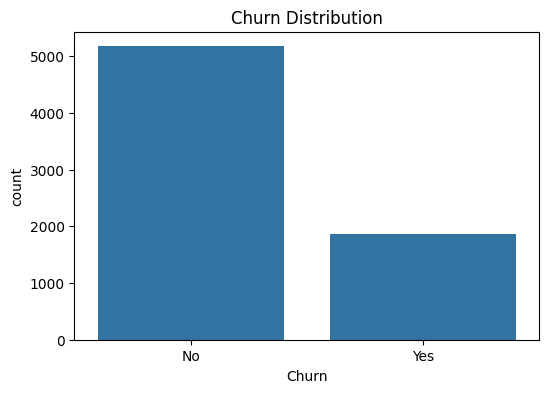


Churn Class Distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


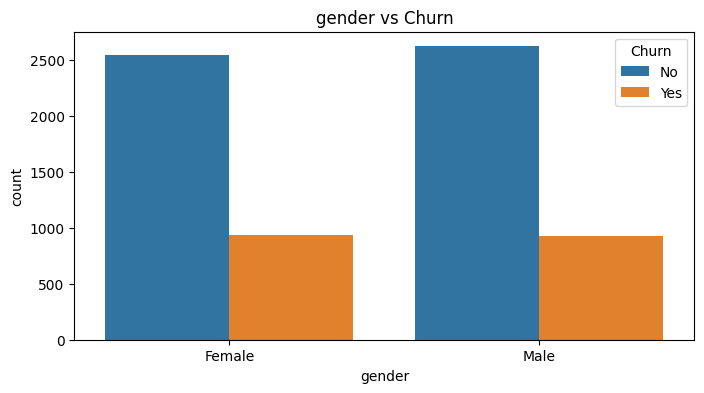

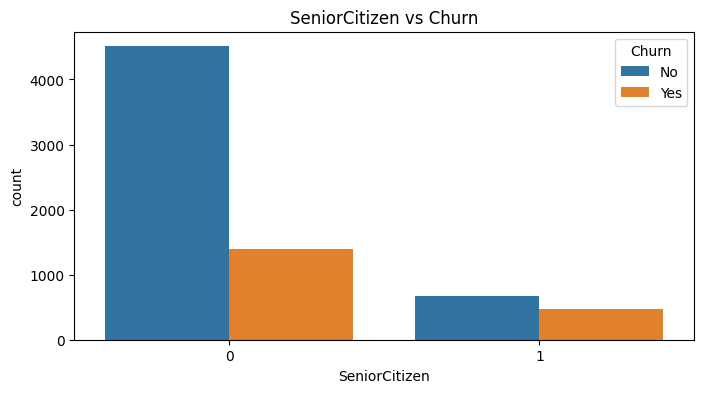

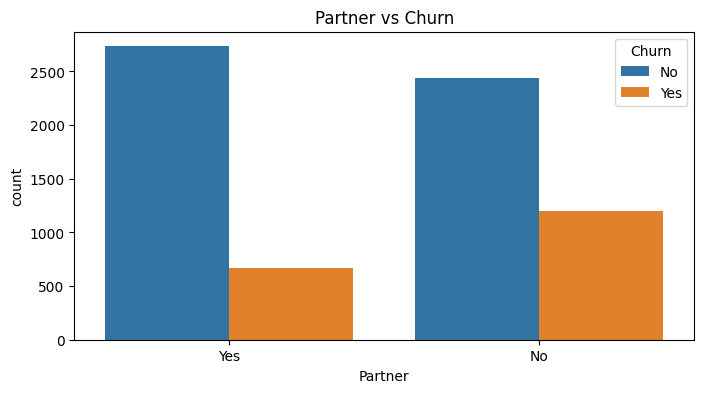

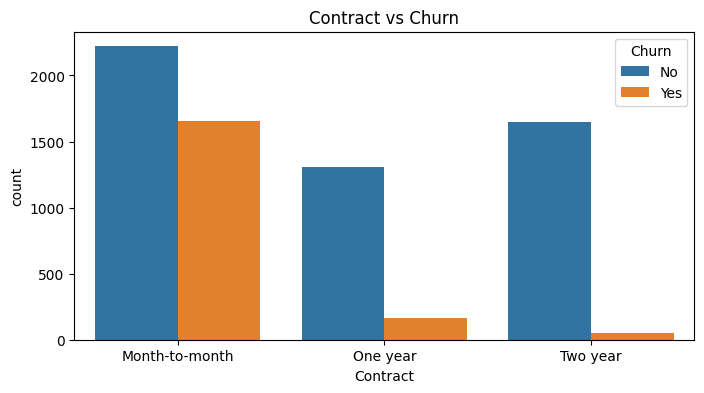

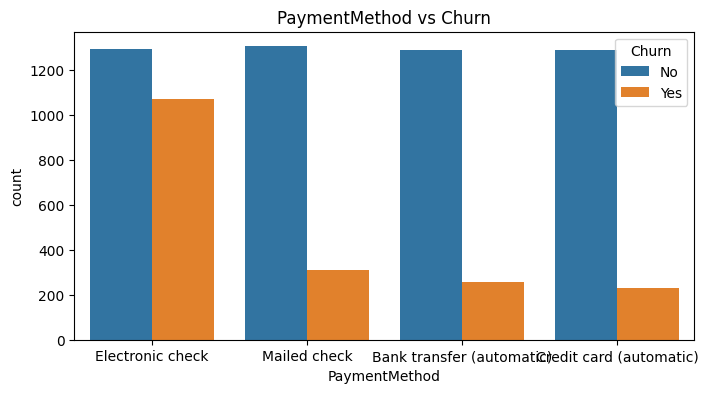

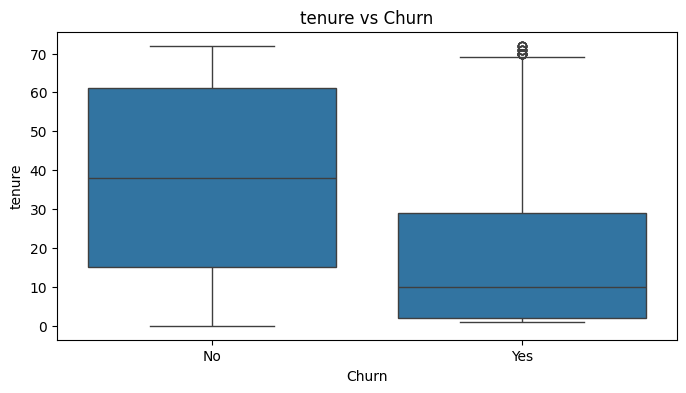

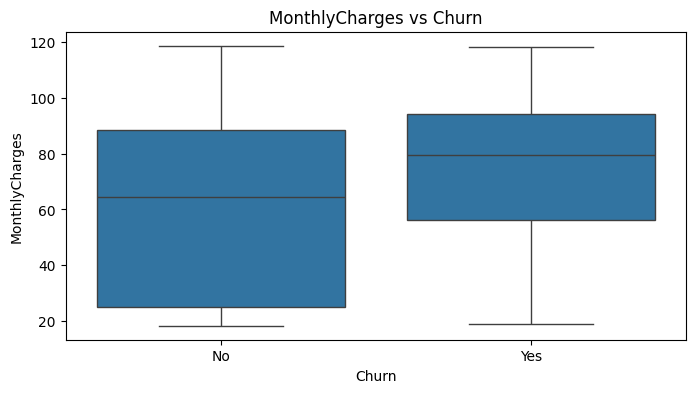

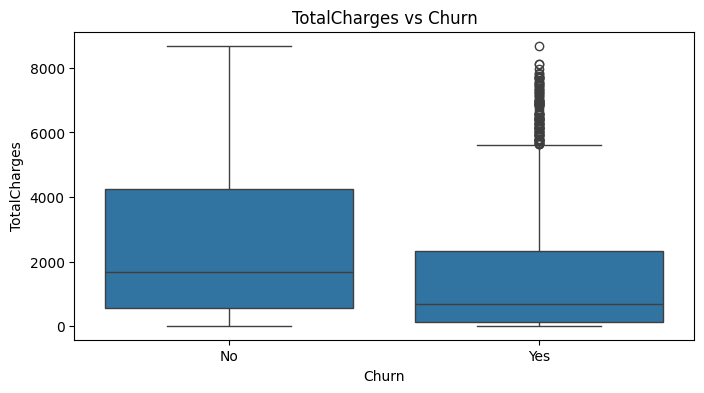

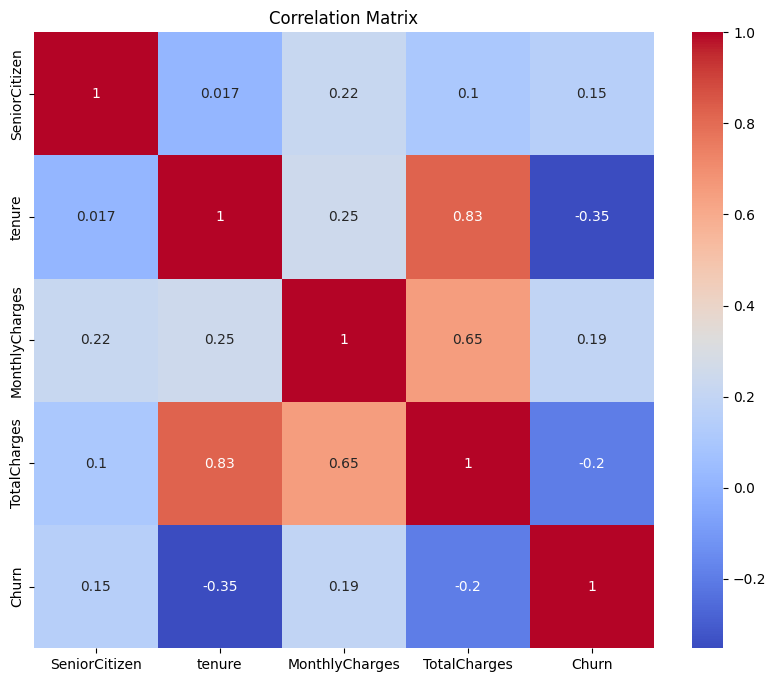

In [3]:
# Churn distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()
print("\nChurn Class Distribution:")
print(df['Churn'].value_counts(normalize=True))

# Categorical features vs Churn 
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Contract', 'PaymentMethod']
for feature in categorical_features:
    plt.figure(figsize=(8,4))
    sns.countplot(x=feature, hue='Churn', data=df)
    plt.title(f'{feature} vs Churn')
    plt.show()

# Numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
for feature in numerical_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='Churn', y=feature, data=df)
    plt.title(f'{feature} vs Churn')
    plt.show()

# Correlation (encode Churn first)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Insights: Document in report (e.g., imbalance, high churn in month-to-month)

In [4]:
# Drop irrelevant column
df.drop('customerID', axis=1, inplace=True)

# Split features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [13]:
# Decision Tree with GridSearchCV
dt = DecisionTreeClassifier(random_state=42)
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
dt_grid = GridSearchCV(dt, dt_param_grid, cv=5, scoring='f1', n_jobs=-1)
dt_grid.fit(X_train_preprocessed, y_train)

best_dt = dt_grid.best_estimator_
print("\nBest Decision Tree Parameters:", dt_grid.best_params_)

# Predictions and evaluation
y_pred_dt = best_dt.predict(X_test_preprocessed)
y_prob_dt = best_dt.predict_proba(X_test_preprocessed)[:, 1]

print("\nDecision Tree Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, y_prob_dt))


Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}

Decision Tree Evaluation:
Accuracy: 0.7608232789212207
Precision: 0.5493333333333333
Recall: 0.5508021390374331
F1 Score: 0.5500667556742324
ROC AUC: 0.7667286677516856


In [14]:
# Neural Network function
def create_nn(learning_rate=0.001, dropout_rate=0.0, hidden_units=64):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X_train_preprocessed.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# KerasClassifier wrapper
nn_model = KerasClassifier(model=create_nn, epochs=50, batch_size=32, verbose=0)

# Hyperparam grid
nn_param_grid = {
    'model__learning_rate': [0.001, 0.01],
    'model__dropout_rate': [0.0, 0.2],
    'model__hidden_units': [64, 128],
    'batch_size': [32, 64]
}

# GridSearchCV
nn_grid = GridSearchCV(nn_model, nn_param_grid, cv=3, scoring='f1', n_jobs=-1)
nn_grid.fit(X_train_preprocessed, y_train, callbacks=[EarlyStopping(monitor='loss', patience=5)])

best_nn = nn_grid.best_estimator_
print("\nBest Neural Network Parameters:", nn_grid.best_params_)

# Predictions and evaluation
y_pred_nn = best_nn.predict(X_test_preprocessed)
y_prob_nn = best_nn.predict_proba(X_test_preprocessed)[:, 1]

print("\nNeural Network Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("Precision:", precision_score(y_test, y_pred_nn))
print("Recall:", recall_score(y_test, y_pred_nn))
print("F1 Score:", f1_score(y_test, y_pred_nn))
print("ROC AUC:", roc_auc_score(y_test, y_prob_nn))

C:\Users\PAVISHANTH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Best Neural Network Parameters: {'batch_size': 64, 'model__dropout_rate': 0.2, 'model__hidden_units': 64, 'model__learning_rate': 0.001}

Neural Network Evaluation:
Accuracy: 0.7927608232789212
Precision: 0.6423611111111112
Recall: 0.4946524064171123
F1 Score: 0.5589123867069486
ROC AUC: 0.8387894288150044


In [16]:
# Save models for viva demo
import joblib
import os

os.makedirs("models", exist_ok=True)
joblib.dump(preprocessor, "models/preprocessor.pkl")
joblib.dump(best_dt, "models/decision_tree.pkl")

# For Keras model
best_nn.model_.save("models/neural_network.h5")

print("Models saved to /models folder!")

Models saved to /models folder!


DECISION TREE - Detailed Results

Best Parameters:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.84      0.84      1035
       Churn       0.55      0.55      0.55       374

    accuracy                           0.76      1409
   macro avg       0.69      0.69      0.69      1409
weighted avg       0.76      0.76      0.76      1409


NEURAL NETWORK - Detailed Results

Best Parameters:
{'batch_size': 64, 'model__dropout_rate': 0.2, 'model__hidden_units': 64, 'model__learning_rate': 0.001}

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.83      0.90      0.86      1035
       Churn       0.64      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409


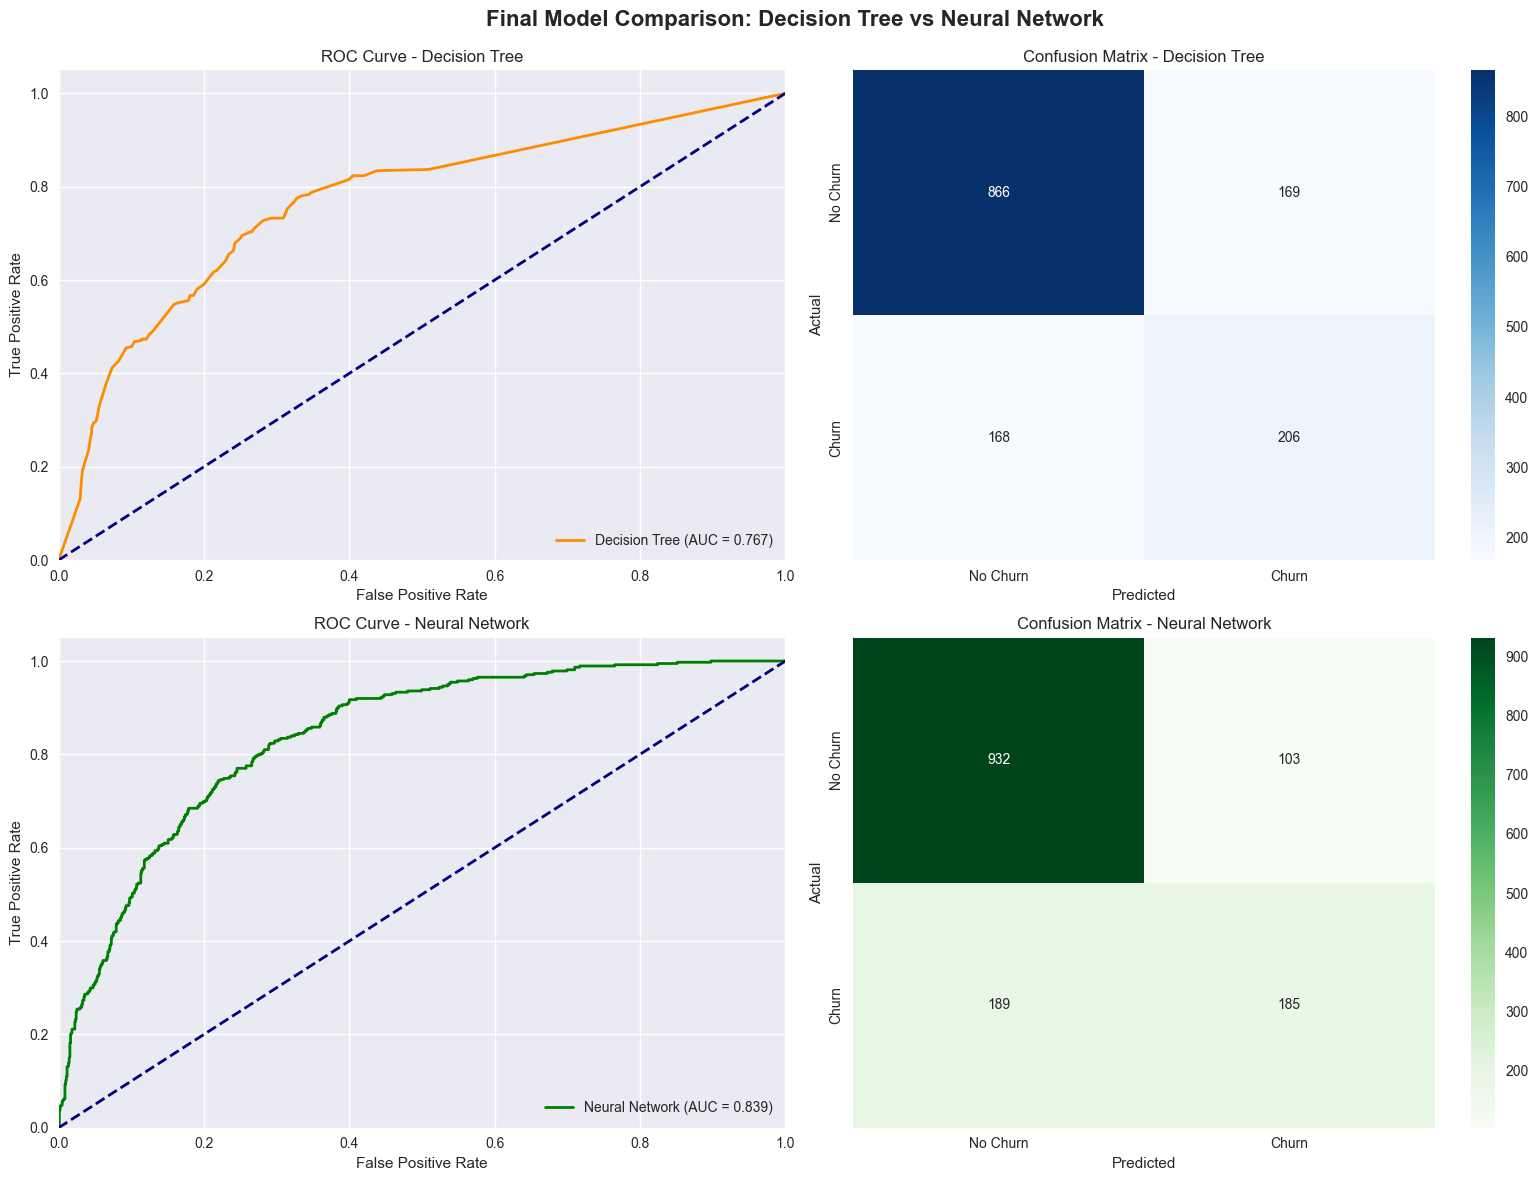


FINAL COMPARISON TABLE
            Model  Accuracy  Precision  Recall  F1-Score  ROC AUC
0   Decision Tree    0.7608     0.5493  0.5508    0.5501   0.7667
1  Neural Network    0.7928     0.6424  0.4947    0.5589   0.8388


In [17]:
# ============================================================
# FINAL EVALUATION: Classification Report + ROC Curve (Both Models)
# ============================================================

from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Set style for beautiful plots
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(16, 12))

# ------------------- 1. Decision Tree -------------------
print("="*60)
print("DECISION TREE - Detailed Results")
print("="*60)

print("\nBest Parameters:")
print(dt_grid.best_params_)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['No Churn', 'Churn']))

# ROC Curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.subplot(2, 2, 1)
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, 
         label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(True)

# Confusion Matrix Heatmap
plt.subplot(2, 2, 2)
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ------------------- 2. Neural Network -------------------
print("\n" + "="*60)
print("NEURAL NETWORK - Detailed Results")
print("="*60)

print("\nBest Parameters:")
print(nn_grid.best_params_)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn, target_names=['No Churn', 'Churn']))

# ROC Curve for Neural Network
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.subplot(2, 2, 3)
plt.plot(fpr_nn, tpr_nn, color='green', lw=2, 
         label=f'Neural Network (AUC = {roc_auc_nn:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend(loc="lower right")
plt.grid(True)

# Confusion Matrix Heatmap
plt.subplot(2, 2, 4)
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Neural Network')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Adjust layout and show
plt.suptitle('Final Model Comparison: Decision Tree vs Neural Network', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# ------------------- Final Comparison Table -------------------
print("\n" + "="*70)
print("FINAL COMPARISON TABLE")
print("="*70)
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Neural Network'],
    'Accuracy': [accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_nn)],
    'Precision': [precision_score(y_test, y_pred_dt), precision_score(y_test, y_pred_nn)],
    'Recall': [recall_score(y_test, y_pred_dt), recall_score(y_test, y_pred_nn)],
    'F1-Score': [f1_score(y_test, y_pred_dt), f1_score(y_test, y_pred_nn)],
    'ROC AUC': [roc_auc_dt, roc_auc_nn]
})
print(results.round(4))